In [5]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from glob import glob
import os
import matplotlib.pyplot as plt
from pandas import DataFrame

In [6]:
!pip install split-folders
import splitfolders

In [7]:
mild = glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
very_mild = glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')
moderate = glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
non = glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')


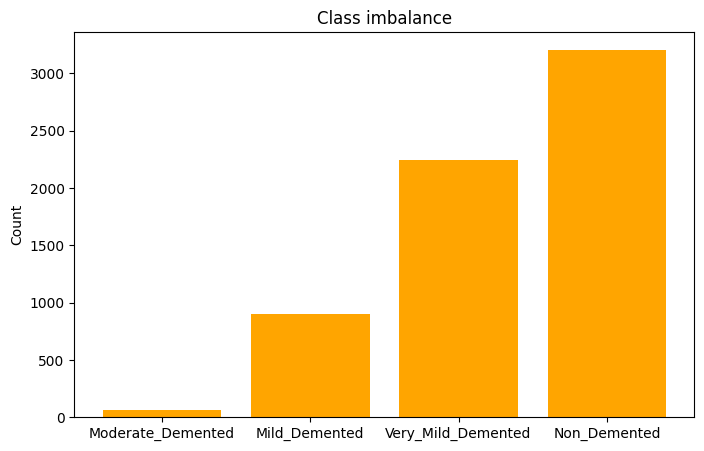

In [8]:
labels = ['Mild_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented']
label_counts = dict()
for class_label in labels:
  label_counts[class_label] = len(os.listdir(f'/kaggle/input/alzheimer-mri-dataset/Dataset/{class_label}/'))

label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(list(label_counts.keys()), list(label_counts.values()), color ='orange')
plt.xlabel('') 
plt.ylabel('Count') 
ax.set_xticks(list(label_counts.keys()))
plt.title('Class imbalance') 

plt.show()

In [9]:
models_accuracy = dict()

In [10]:
def extract_class_weights():
    class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
    
    class_counts = dict()
    for name in class_names:
        class_counts[name] = len(os.listdir('/kaggle/input/alzheimer-mri-dataset/Dataset/' + name))
    
    total = sum(class_counts.values())
    num_classes = len(class_names)
    
    class_weights = dict()
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * list(class_counts.values())[i])
        print('{} {}: {:.2}'.format(i+1, class_names[i], class_weights[i]))
        
    return class_weights

extract_class_weights()

1 Mild_Demented: 1.8
2 Moderate_Demented: 2.5e+01
3 Non_Demented: 0.5
4 Very_Mild_Demented: 0.71


{0: 1.7857142857142858, 1: 25.0, 2: 0.5, 3: 0.7142857142857143}

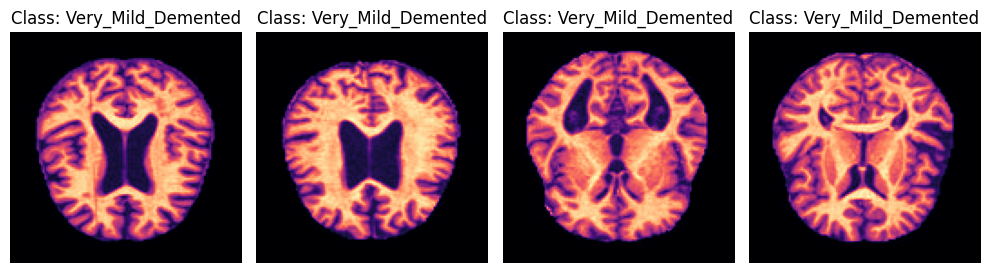

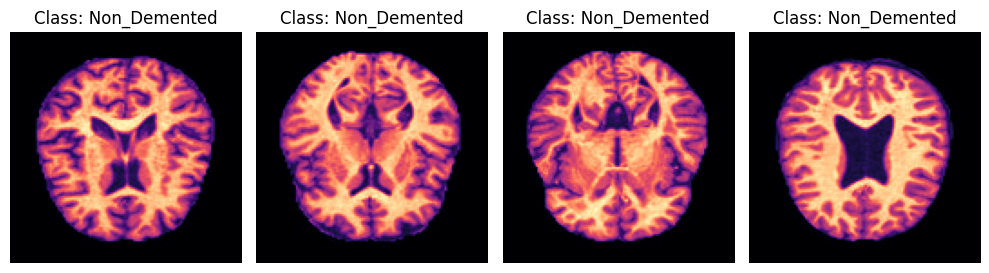

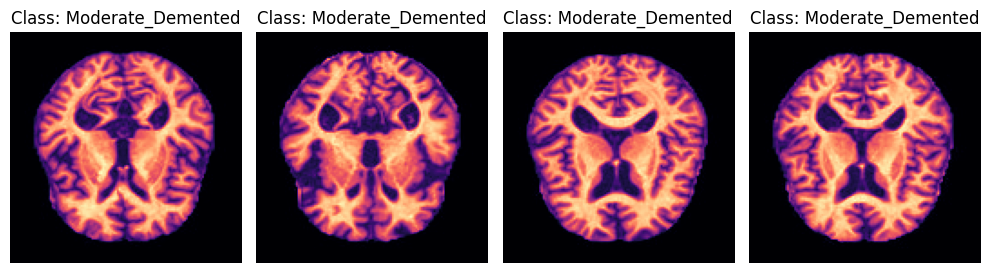

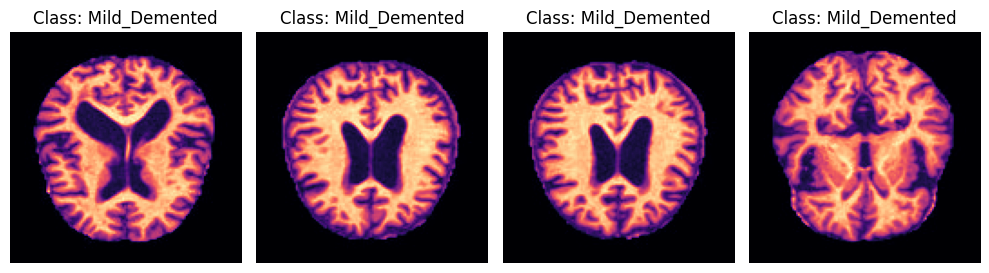

In [11]:

def display_images(label):
    import random
    from matplotlib.image import imread
    from pathlib import PurePath
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 6), tight_layout=True)
    axs = axs.ravel()
    

    img_list = random.sample(label, 4)
    
    for i, img_path in enumerate(img_list):
        img = imread(img_path)
        label = PurePath(img_path).parent.name
        axs[i].set_title(f'Class: {label}', fontsize=12)
        axs[i].imshow(img, cmap='magma')
        axs[i].axis('off')
    plt.show()
    
display_images(very_mild)
display_images(non)
display_images(moderate)
display_images(mild)

In [12]:
import numpy as np

resized_image_array = []
resized_image_array_label = []

def resize_images(image_directory):
    from PIL import Image
    
    target_size = (224, 224)
    
    for file in image_directory:
        img = Image.open(file)
        
        img = img.resize(target_size)
        array_temp = np.array(img)
        
        shape_new = 224 * 224
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        
        if image_directory == non:
            resized_image_array_label.append(0)
        elif image_directory == very_mild:
            resized_image_array_label.append(1)
        elif image_directory == mild:
            resized_image_array_label.append(2)
        elif image_directory == moderate:
            resized_image_array_label.append(3)
            
resize_images(non)
resize_images(mild)
resize_images(very_mild)
resize_images(moderate)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resized_image_array, resized_image_array_label,
                                                    test_size=0.2, shuffle=True, random_state=7)
print('Train images:', len(X_train))
print('Test images:', len(X_test))

Train images: 5120
Test images: 1280


In [13]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [14]:
classes_weights

array([0.49883087, 0.49883087, 0.72194021, ..., 0.49883087, 0.49883087,
       0.72194021])

In [15]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric="auc",early_stopping_rounds=10, device="cuda")
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], sample_weight=classes_weights)

[0]	validation_0-auc:0.80451
[1]	validation_0-auc:0.85184
[2]	validation_0-auc:0.87522
[3]	validation_0-auc:0.89455
[4]	validation_0-auc:0.90509
[5]	validation_0-auc:0.92083
[6]	validation_0-auc:0.92615
[7]	validation_0-auc:0.93573
[8]	validation_0-auc:0.94369
[9]	validation_0-auc:0.94847
[10]	validation_0-auc:0.95573
[11]	validation_0-auc:0.96032
[12]	validation_0-auc:0.96355
[13]	validation_0-auc:0.96770
[14]	validation_0-auc:0.97200
[15]	validation_0-auc:0.97523
[16]	validation_0-auc:0.97789
[17]	validation_0-auc:0.97985
[18]	validation_0-auc:0.98214
[19]	validation_0-auc:0.98347
[20]	validation_0-auc:0.98462
[21]	validation_0-auc:0.98591
[22]	validation_0-auc:0.98707
[23]	validation_0-auc:0.98846
[24]	validation_0-auc:0.98964
[25]	validation_0-auc:0.99045
[26]	validation_0-auc:0.99139
[27]	validation_0-auc:0.99215
[28]	validation_0-auc:0.99298
[29]	validation_0-auc:0.99352
[30]	validation_0-auc:0.99406
[31]	validation_0-auc:0.99453
[32]	validation_0-auc:0.99484
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
models_accuracy['XGBoost'] = int(acc * 10000)/100
print('Test accuracy: {:.4f}'.format(acc))
print('Test F1 score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('Misclassified images: {} out of {}'.format((y_test != y_pred).sum(), len(y_test)))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:33:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Test accuracy: 0.9836
Test F1 score: 0.9835
Misclassified images: 21 out of 1280


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

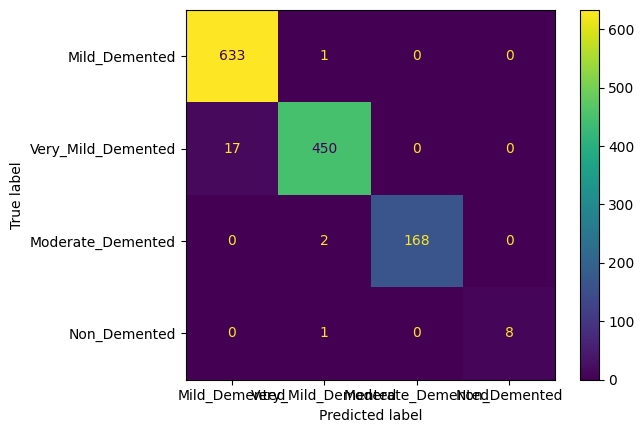

In [18]:
d = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=labels)
d.plot()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       634
           1       0.99      0.96      0.98       467
           2       1.00      0.99      0.99       170
           3       1.00      0.89      0.94         9

    accuracy                           0.98      1280
   macro avg       0.99      0.96      0.97      1280
weighted avg       0.98      0.98      0.98      1280



In [20]:
splitfolders.ratio('/kaggle/input/alzheimer-mri-dataset/Dataset', output="output", seed=1345, ratio=(.8, 0.2)) 

Copying files: 6400 files [00:06, 1001.38 files/s]


In [21]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/kaggle/working/output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=61
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/kaggle/working/output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=61
)

Found 5119 files belonging to 4 classes.
Found 1281 files belonging to 4 classes.


In [22]:
import keras

model = keras.models.Sequential()
model.add(keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,activation='relu',kernel_size=3,kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,activation='relu',kernel_size=3,kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,activation='relu',kernel_size=3,kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,637,860 (6.25 MB)

 Trainable params: 1,637,860 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, verbose=1, patience=5,
                                      restore_best_weights=True)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

cnn_model_hist = model.fit(train_ds,
                        epochs=100,
                       
                        class_weight={0: 1.8, 1: 2.5, 2: 0.5, 3: 0.71},
                        validation_data=test_ds, callbacks=[early_stopping_cb])

Epoch 1/100


2024-09-02 21:33:56.878134: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 451: 4.0254, expected 3.48178
2024-09-02 21:33:56.878199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 590: 4.02316, expected 3.47954
2024-09-02 21:33:56.878216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 932: 4.2157, expected 3.67208
2024-09-02 21:33:56.878234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1364: 4.41386, expected 3.87024
2024-09-02 21:33:56.878245: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1365: 4.2562, expected 3.71258
2024-09-02 21:33:56.878270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3510: 4.10101, expected 3.55739
2024-09-02 21:33:56.878287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4246: 4.2123, expected 3.66868
2024-09-02 21:33:56.878299: E external/lo

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2901 - loss: 4.7851 

I0000 00:00:1725312841.068747     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3558 - loss: 2.4830

2024-09-02 21:34:03.249190: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 5.92194, expected 5.15549
2024-09-02 21:34:03.249248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.30996, expected 5.54351
2024-09-02 21:34:03.249263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.09949, expected 5.33304
2024-09-02 21:34:03.249281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.38103, expected 4.61458
2024-09-02 21:34:03.249294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.86374, expected 4.09729
2024-09-02 21:34:03.249305: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.44152, expected 4.67507
2024-09-02 21:34:03.249316: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.96449, expected 4.19804
2024-09-02 21:34:03.249327: E external/local_xla/xla/se

84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.3604 - loss: 2.3898 - val_accuracy: 0.4996 - val_loss: 1.3138
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4826 - loss: 0.8388 - val_accuracy: 0.5246 - val_loss: 1.0043
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5562 - loss: 0.7469 - val_accuracy: 0.5941 - val_loss: 0.8242
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6077 - loss: 0.6671 - val_accuracy: 0.5988 - val_loss: 0.8166
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6561 - loss: 0.5720 - val_accuracy: 0.6706 - val_loss: 0.6792
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7437 - loss: 0.4498 - val_accuracy: 0.7408 - val_loss: 0.5329
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7853 - loss: 0.3650 - val_accuracy: 0.7377 - val_loss: 0.5442
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8125 - loss: 0.3141 - val_accuracy: 0.8447 - val_

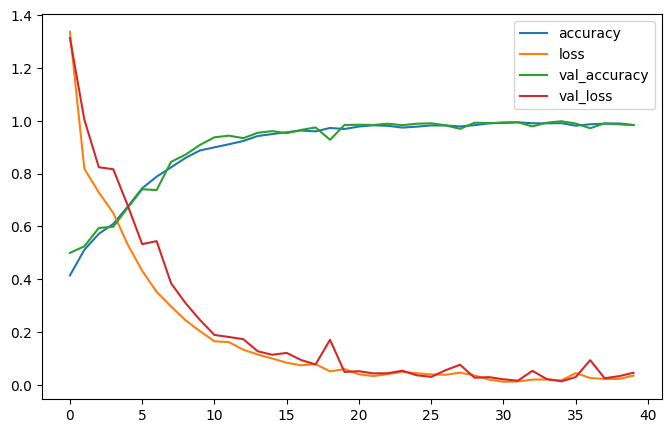

In [25]:
pd.DataFrame(cnn_model_hist.history).plot(figsize=(8,5))
plt.show()

In [26]:
val_loss, val_accuracy = model.evaluate(test_ds, verbose=1)
models_accuracy['CNN'] = int(val_accuracy * 10000)/100
print('Test accuracy: {:.4f}'.format(val_accuracy))
num_misclass = int((1 - val_accuracy) * len(test_ds) * 61)
print('Misclassified images: {} out of {}'.format(num_misclass, len(test_ds) * 61))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0141
Test accuracy: 0.9984
Misclassified images: 2 out of 1281


In [27]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

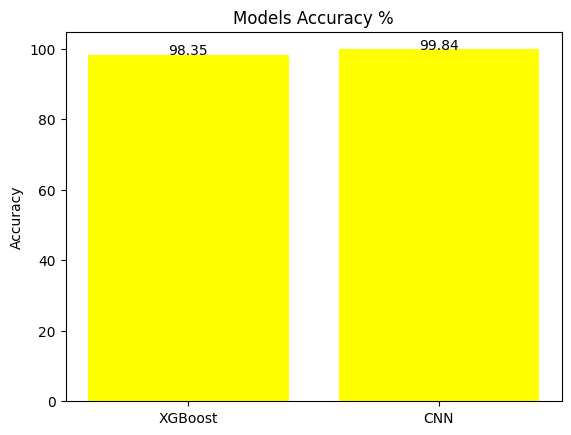

In [28]:
plt.bar(list(models_accuracy.keys()), list(models_accuracy.values()), color ='yellow')

addlabels(list(models_accuracy.keys()), list(models_accuracy.values()))
plt.xlabel('') 
plt.ylabel('Accuracy') 
plt.title('Models Accuracy %') 

plt.show()